In [1]:
from matplotlib.collections import LineCollection
from matplotlib import pyplot as plt
from matplotlib import cm, colors
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

np.set_printoptions(linewidth=300, suppress=True)
pd.options.mode.chained_assignment = None  # default='warn'

from src.experiments.util_experiments import *
from src.oom import DiscreteValuedOOM, ContinuousValuedOOM
from src.oom.util.few_step_prediction import quantify_distribution

from matplotlib.collections import LineCollection
from matplotlib import pyplot as plt
from matplotlib import cm, colors
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from hmmlearn import hmm
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

np.set_printoptions(linewidth=300, suppress=True)
pd.options.mode.chained_assignment = None  # default='warn'

from src.experiments.util_experiments import *
from src.oom import DiscreteValuedOOM, ContinuousValuedOOM
from src.oom.discrete_observable import DiscreteObservable
from src.oom.util.few_step_prediction import quantify_distribution, kl_divergence, fix_pvec
from src.oom.util.random_sparse import _generate_sparse_full_rank_matrix, _generate_observable_compound
from src.oom.util.learning_discrete import estimate_matrices_discrete_fixed
from src.oom.util.learning_continuous import get_transfer_matrix

In [8]:
def compute_cross_entropy(source_oom, sequence, F_YX, indexing):
    total_nll = 0.0
    valid_terms = 0
    
    for t in range(3, len(sequence)):
        history, next_symbol = sequence[t-3 : t], sequence[t]
        index = "".join([obs.uid for obs in history])
        col_idx = indexing.index(index)
        next_idx = source_oom.observables.index(next_symbol)
        
        # Get probability from F_YX
        prob = F_YX[col_idx, next_idx]
        
        # Avoid log(0) by adding a tiny epsilon (e.g., 1e-12) if necessary
        if prob == 0:
            prob = 1e-12  # Handle zero probabilities gracefully
        
        total_nll += -np.log2(prob)
        valid_terms += 1
    
    # Step 3: Compute average NLL (cross-entropy)
    H_fq3 = total_nll / valid_terms
    return H_fq3

In [39]:
def optimize_discrete(n: int, d: int, density: float, max_seeds: int) -> pd.Series:
    # Define results dictionary
    metrics_dv = {
        "spectral_gap": [],
        "geo_mean_var": [],
        "perc0fs_at_7": [],
        "H_q3": [],
        "H_f": [],
        "H_uniform": []
    }

    # Iterate through first max_seeds seeds
    description = f"Discrete-Valued Source Optimization ({n=} {d=} {density=})"
    for DVSEED in tqdm(range(max_seeds), desc = description):
        # Create source OOM as an HMM with the given paramters for this seed
        oom_disc = make_source(dimension = d, alphabet_size = n, density = density, seed = DVSEED)

        quant7 = quantify_distribution(steps=7, state=oom_disc.start_state, operators=oom_disc.operators, lin_func=oom_disc.lin_func)
        perc0fs_at_7 = np.average(quant7 == 0)
        # print(perc0fs_at_7)
        if perc0fs_at_7 > n**(-2):
            continue
        
        # Compute spectral gap
        transition_matrix = np.sum(oom_disc.operators, axis = 0)
        eigenvalues, _ = np.linalg.eig(transition_matrix)
        eigenvalues = np.sort(np.abs(eigenvalues))[::-1]  # Sort eigenvalues
        spectral_gap = eigenvalues[0] - eigenvalues[1]    # Spectral gap

        # Compute entropies
        gen = oom_disc.generate(10_000, reduced=False)
        estimate_matrices_3rdorder = estimate_matrices_discrete_fixed(
            sequence=gen.sequence,
            len_cwords=1,
            len_iwords=3,
            indexing=True
        )
        indexing = list(estimate_matrices_3rdorder[-1])
        F_YX_3rdorder = estimate_matrices_3rdorder[0][0]
        F_YX_3rdorder /= F_YX_3rdorder.sum(axis=0)
        
        nll_3rdorder = compute_cross_entropy(oom_disc, gen.sequence, F_YX_3rdorder, indexing)
        nll_f = gen.nll_list[-1]
    
        # Compute geometric mean of variances on PC1, PC2 axes
        pvecs = np.vstack([pvec for pvec in gen.p_vec_list if not np.any(np.isnan(pvec))])
        pvs_embeds_pca = PCA(n_components = 2).fit_transform(pvecs)
        x_pca = pvs_embeds_pca[:,0]
        y_pca = pvs_embeds_pca[:,1]
        var_pc1 = np.var(x_pca)
        var_pc2 = np.var(y_pca)
        geometric_mean = np.sqrt(var_pc1 * var_pc2)
    
        # Save results
        metrics_dv["spectral_gap"].append(spectral_gap)
        metrics_dv["geo_mean_var"].append(geometric_mean)
        metrics_dv["perc0fs_at_7"].append(perc0fs_at_7)
        metrics_dv["H_q3"].append(nll_3rdorder)
        metrics_dv["H_f"].append(nll_f)
        metrics_dv["H_uniform"].append(np.log2(n))

    # Convert to pandas
    metrics_dv_df = pd.DataFrame(metrics_dv)

    # print(metrics_dv)

    # Process and reorder columns
    metrics_dv_df = metrics_dv_df.reset_index().rename({"index": "DVSEED"}, axis = 1)
    metrics_dv_df["_ent_diff"] = metrics_dv_df["H_q3"] - metrics_dv_df["H_f"]
    metrics_dv_df["_norm_spectral_gap"] = 1 - (metrics_dv_df["spectral_gap"] - metrics_dv_df["spectral_gap"].min()) / (metrics_dv_df["spectral_gap"].max() - metrics_dv_df["spectral_gap"].min())
    metrics_dv_df["_norm_geo_mean_var"] = (metrics_dv_df["geo_mean_var"] - metrics_dv_df["geo_mean_var"].min()) / (metrics_dv_df["geo_mean_var"].max() - metrics_dv_df["geo_mean_var"].min())
    metrics_dv_df["_norm_weighted_sum"] = 0.5 * (metrics_dv_df["_norm_spectral_gap"] + metrics_dv_df["_norm_geo_mean_var"])
    
    metrics_dv_df = metrics_dv_df.sort_values(["_ent_diff", "_norm_weighted_sum"], ascending=False).query("H_f < H_uniform & _norm_weighted_sum > 0.5")
    dv_seed_best = metrics_dv_df["DVSEED"].iloc[0]
    oom_disc_stats = metrics_dv_df.iloc[0]
    return dv_seed_best, oom_disc_stats, metrics_dv_df

In [43]:
S_3_results = optimize_discrete(3, 10, 0.4, 100)

Discrete-Valued Source Optimization (n=3 d=10 density=0.4): 100%|████████████████████| 100/100 [01:17<00:00,  1.29it/s]


In [45]:
S_3_results[2]

,DVSEED,spectral_gap,geo_mean_var,perc0fs_at_7,H_q3,H_f,H_uniform,_ent_diff,_norm_spectral_gap,_norm_geo_mean_var,_norm_weighted_sum
44,44,0.230524,0.023078,0.000000,7.496948,1.160497,1.584963,6.336450,0.853402,0.509285,0.681344
31,31,0.380404,0.023631,0.069959,6.811787,1.359266,1.584963,5.452521,0.510578,0.521735,0.516156
15,15,0.294908,0.016568,0.000000,6.383709,1.394160,1.584963,4.989549,0.706136,0.362702,0.534419
24,24,0.166433,0.031638,0.005487,6.148529,1.234611,1.584963,4.913917,1.000000,0.702007,0.851004
58,58,0.282622,0.024004,0.000000,5.546511,1.258251,1.584963,4.288261,0.734238,0.530121,0.632180
35,35,0.462164,0.044874,0.000000,5.501726,1.287992,1.584963,4.213734,0.323566,1.000000,0.661783
28,28,0.476622,0.033037,0.000000,5.361580,1.422901,1.584963,3.938679,0.290496,0.733500,0.511998


In [46]:
S_3_results[1]

DVSEED                44.000000
spectral_gap           0.230524
geo_mean_var           0.023078
perc0fs_at_7           0.000000
H_q3                   7.496948
H_f                    1.160497
H_uniform              1.584963
_ent_diff              6.336450
_norm_spectral_gap     0.853402
_norm_geo_mean_var     0.509285
_norm_weighted_sum     0.681344
Name: 44, dtype: float64

In [44]:
S_5_results = optimize_discrete(5, 10, 0.4, 100)

Discrete-Valued Source Optimization (n=5 d=10 density=0.4): 100%|████████████████████| 100/100 [04:30<00:00,  2.70s/it]


In [47]:
S_5_results[2]

,DVSEED,spectral_gap,geo_mean_var,perc0fs_at_7,H_q3,H_f,H_uniform,_ent_diff,_norm_spectral_gap,_norm_geo_mean_var,_norm_weighted_sum
13,13,0.289279,0.040515,0.022502,20.205908,1.591012,2.321928,18.614896,0.719011,0.975325,0.847168
0,0,0.379462,0.027837,0.000000,17.908247,1.645087,2.321928,16.263160,0.512732,0.658861,0.585797
5,5,0.524639,0.041503,0.000000,11.951314,1.866645,2.321928,10.084670,0.180665,1.000000,0.590333
15,15,0.166433,0.018497,0.011827,12.018094,1.943256,2.321928,10.074838,1.000000,0.425737,0.712869
20,20,0.380404,0.025324,0.021606,10.314301,2.043117,2.321928,8.271184,0.510578,0.596133,0.553355
46,46,0.408418,0.025963,0.004275,8.780326,1.987432,2.321928,6.792895,0.446501,0.612096,0.529298
9,9,0.294908,0.023415,0.000000,8.643592,2.103061,2.321928,6.540530,0.706136,0.548486,0.627311
10,10,0.352484,0.024759,0.018893,8.559988,2.103870,2.321928,6.456118,0.574440,0.582033,0.578237


In [48]:
S_5_results[1]

DVSEED                13.000000
spectral_gap           0.289279
geo_mean_var           0.040515
perc0fs_at_7           0.022502
H_q3                  20.205908
H_f                    1.591012
H_uniform              2.321928
_ent_diff             18.614896
_norm_spectral_gap     0.719011
_norm_geo_mean_var     0.975325
_norm_weighted_sum     0.847168
Name: 13, dtype: float64

In [50]:
S_3_disc_oom = make_source(alphabet_size=3, dimension=10, density=0.4, seed=int(S_3_results[0]))
S_3_results_cont = optimize_continuous(S_3_disc_oom, 100)

Blended Source Optimization (n=3 d=10): 100%|████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/it]


In [51]:
S_3_results_cont[2]

,MFSEED,geo_mean_var,norm_geo_mean_var
0,85,0.011369,1.000000
1,65,0.009545,0.834965
2,36,0.008778,0.765583
3,35,0.008188,0.712256
4,64,0.007597,0.658785
...,...,...,...
95,19,0.000639,0.029297
96,54,0.000592,0.025049
97,12,0.000448,0.012013
98,52,0.000421,0.009532


In [52]:
S_3_results_cont[1]

MFSEED               85.000000
geo_mean_var          0.011369
norm_geo_mean_var     1.000000
Name: 0, dtype: float64

In [53]:
S_5_disc_oom = make_source(alphabet_size=5, dimension=10, density=0.4, seed=int(S_5_results[0]))
S_5_results_cont = optimize_continuous(S_5_disc_oom, 100)

Blended Source Optimization (n=5 d=10): 100%|████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]


In [54]:
S_5_results_cont[2]

,MFSEED,geo_mean_var,norm_geo_mean_var
0,74,0.005838,1.000000
1,85,0.005477,0.934927
2,65,0.005334,0.909046
3,37,0.004561,0.769696
4,42,0.004407,0.741902
...,...,...,...
95,56,0.000402,0.019750
96,62,0.000390,0.017567
97,94,0.000373,0.014543
98,15,0.000320,0.004971


In [55]:
S_5_results_cont[1]

MFSEED               74.000000
geo_mean_var          0.005838
norm_geo_mean_var     1.000000
Name: 0, dtype: float64

In [57]:
def plot_pca_results(x_pca, y_pca, fig, ax, title, scale='auto'):
    ax.set_title(title)
    points = np.array([x_pca, y_pca]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis = 1)
    cols = np.linspace(0, 1, len(x_pca))

    cmap = sns.color_palette("flare", as_cmap=True)
    lc = LineCollection(segments, cmap = cmap, alpha = 0.5)
    lc.set_array(cols)
    lc.set_linewidth(0.15)
    line = ax.add_collection(lc)

    if scale == 'auto':
        ax.autoscale()
    else:
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
    
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    fig.colorbar(line, ax = ax)

def make_plot(oom, gen, fig, ax, title):
    pvecs = np.vstack([pvec for pvec in gen.p_vec_list if not np.any(np.isnan(pvec))])
    
    pvs_embeds_pca = PCA(n_components = 2).fit_transform(pvecs)
    
    x_pca = pvs_embeds_pca[:,0]
    y_pca = pvs_embeds_pca[:,1]
    
    plot_pca_results(x_pca, y_pca, fig, ax, title, scale=0)

def plot_mfs(cvoom, fig, ax, title, xlim = (-5, 5)):
    xlimi, xlims = xlim
    ax.set_title(title)
    ax.set_xlim([xlimi, xlims])
    
    x = np.linspace(xlimi, xlims, (xlims - xlimi) * 1000)
    for obs, mf in zip(cvoom.observables, cvoom.membership_fns):
        ax.plot(x, mf.pdf(x), label=obs.uid)
    ax.legend()

    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

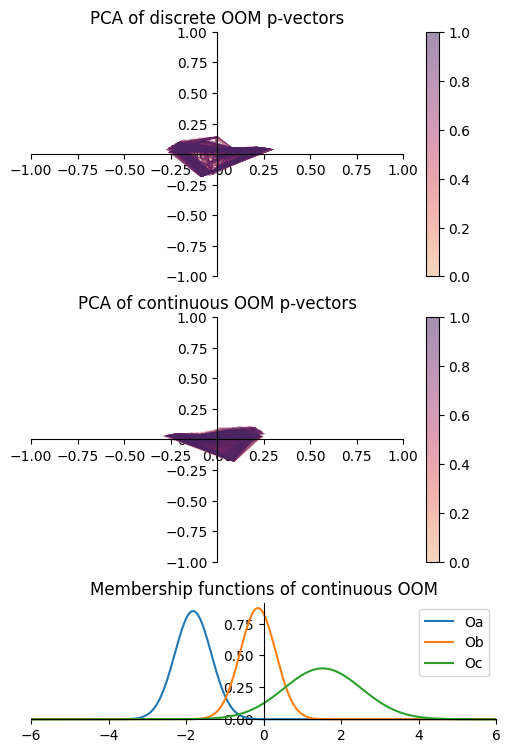

In [58]:
fig, axs = plt.subplots(3, 1, figsize=(6, 9), height_ratios=[1, 1, 0.5])
axs = axs.flatten()

# oom_disc = make_source(dimension = d, alphabet_size = n, density = density, seed = 10)
# mfs = get_gaussian(seed = 10)(n)
# oom_cont = ContinuousValuedOOM.from_discrete_valued_oom(oom_disc, mfs)
oom_disc = make_source(alphabet_size=3, dimension=10, density=0.4, seed=int(S_3_results[0]))
oom_cont = ContinuousValuedOOM.from_discrete_valued_oom(
    oom_disc,
    membership_functions=get_gaussian(seed=int(S_3_results_cont[0]))(len(oom_disc.observables))
)

gen_disc = oom_disc.generate(10000, reduced = False)
gen_cont = oom_cont.generate(10000, reduced = False)

make_plot(oom_disc, gen_disc, fig, axs[0], "PCA of discrete OOM p-vectors")
make_plot(oom_cont, gen_cont, fig, axs[1], "PCA of continuous OOM p-vectors")
plot_mfs(oom_cont, fig, axs[2], "Membership functions of continuous OOM", xlim=(-6, 6))

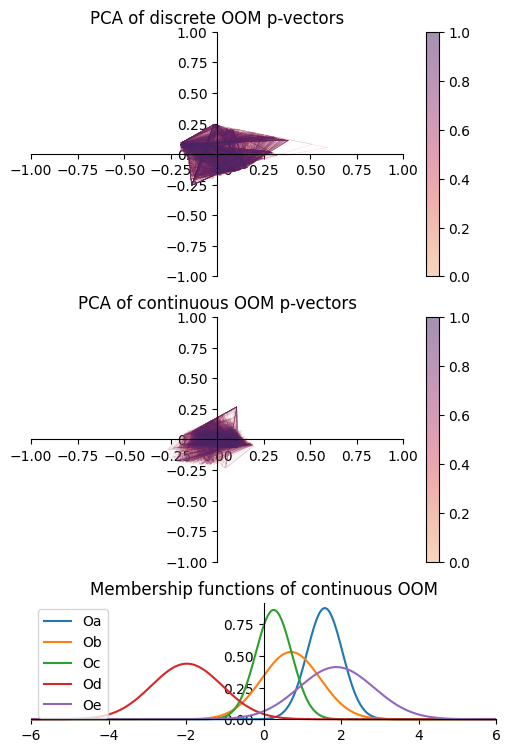

In [59]:
fig, axs = plt.subplots(3, 1, figsize=(6, 9), height_ratios=[1, 1, 0.5])
axs = axs.flatten()

# oom_disc = make_source(dimension = d, alphabet_size = n, density = density, seed = 10)
# mfs = get_gaussian(seed = 10)(n)
# oom_cont = ContinuousValuedOOM.from_discrete_valued_oom(oom_disc, mfs)
oom_disc = make_source(alphabet_size=5, dimension=10, density=0.4, seed=int(S_5_results[0]))
oom_cont = ContinuousValuedOOM.from_discrete_valued_oom(
    oom_disc,
    membership_functions=get_gaussian(seed=int(S_5_results_cont[0]))(len(oom_disc.observables))
)

gen_disc = oom_disc.generate(10000, reduced = False)
gen_cont = oom_cont.generate(10000, reduced = False)

make_plot(oom_disc, gen_disc, fig, axs[0], "PCA of discrete OOM p-vectors")
make_plot(oom_cont, gen_cont, fig, axs[1], "PCA of continuous OOM p-vectors")
plot_mfs(oom_cont, fig, axs[2], "Membership functions of continuous OOM", xlim=(-6, 6))

In [5]:
T_inv_3 = get_transfer_matrix(
    mfn_dict = dict(zip(range(3), get_gaussian(seed=85)(3))),
    save_to_files=False
)
print(T_inv_3)

[[ 1.6710206  -0.06474015  0.00426015]
 [-0.06474015  1.75942529 -0.71472639]
 [ 0.00426015 -0.71472639  3.83693174]]


In [6]:
print(np.linalg.inv(T_inv_3))

[[0.5993402  0.02356639 0.00372439]
 [0.02356639 0.6158234  0.11468665]
 [0.00372439 0.11468665 0.28198409]]


<Axes: >

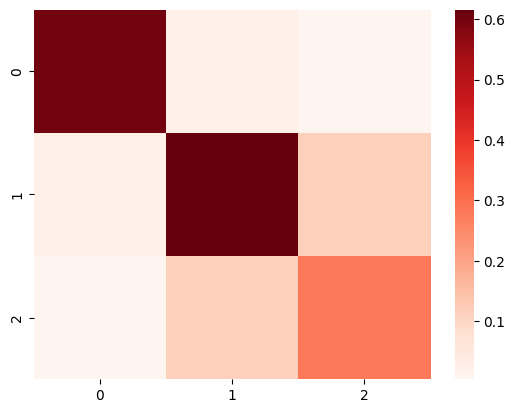

In [11]:
sns.heatmap(np.linalg.inv(T_inv_3), cmap="Reds")

In [3]:
T_inv_5 = get_transfer_matrix(
    mfn_dict = dict(zip(range(5), get_gaussian(seed=74)(5))),
    save_to_files=False
)
print(T_inv_5)

[[ 10.15964116 -11.66878465   7.75987977   0.15346435  -7.43180166]
 [-11.66878465  31.90884721 -19.23123341  -0.39185163  -0.33974035]
 [  7.75987977 -19.23123341  13.47899578   0.04430099  -1.46612659]
 [  0.15346435  -0.39185163   0.04430099   3.25556582   0.0207613 ]
 [ -7.43180166  -0.33974035  -1.46612659   0.0207613   13.43652882]]


In [4]:
print(np.linalg.inv(T_inv_5))

[[0.6190967  0.27749984 0.07844673 0.00086672 0.35799995]
 [0.27749984 0.37482129 0.39737588 0.02531085 0.2062842 ]
 [0.07844673 0.39737588 0.60890388 0.03508173 0.11982313]
 [0.00086672 0.02531085 0.03508173 0.30966603 0.00446883]
 [0.35799995 0.2062842  0.11982313 0.00446883 0.29071874]]


<Axes: >

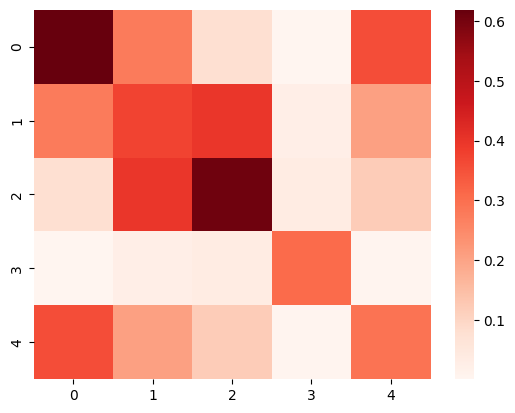

In [12]:
sns.heatmap(np.linalg.inv(T_inv_5), cmap="Reds")